<a href="https://colab.research.google.com/github/ashmitamittal/NLP-Models-Playground/blob/main/neo4j_rag_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangChain x Neo4j x RAG x LLM

### Streamlining data ingestion and querying in retrieval-augmented generation applications

[Reference article](https://neo4j.com/developer-blog/langchain-library-full-support-neo4j-vector-index/)

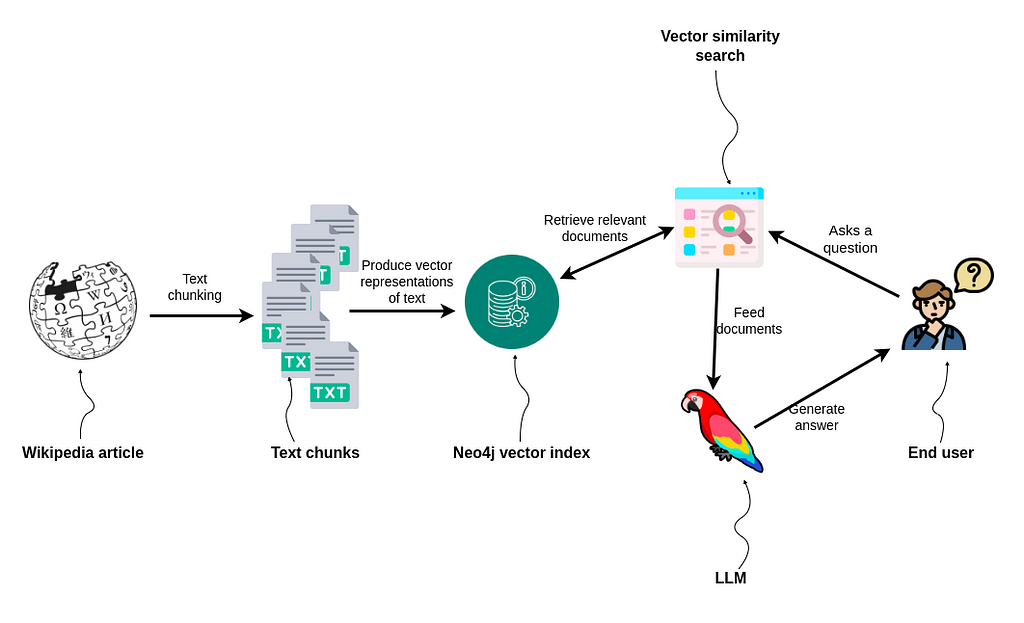

In [ ]:
!pip install langchain openai wikipedia tiktoken neo4j

In [39]:
import os

from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.document_loaders import WikipediaLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter

os.environ['OPENAI_API_KEY'] = ""


## Reading and Chunking a Wikipedia Article
- tiktoken text chunking module, which uses a tokenizer made by OpenAI, to split the article into chunks with 1000 tokens
- removing summaries from documents due to redundancy

In [45]:
# Read the wikipedia article
raw_documents = WikipediaLoader(query="Leonhard Euler").load()
# Define chunking strategy
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=20
)
# Chunk the document
documents = text_splitter.split_documents(raw_documents)

# Remove summary from metadata
for d in documents:
    del d.metadata['summary']


## Store and Index the Text With Neo4j

- Import the docs into Neo4j using Langchain
- Index docs using the vector index
- Neo4j vector index is wrapped as a Langchain vector store

`from_documents`
- connecting to Neo4j database
- imports and enbeds documents
- creates a vector index
- data represented as "Chunk" nodes

In [46]:
from langchain.vectorstores import Neo4jVector
from langchain.embeddings.openai import OpenAIEmbeddings

# Neo4j Aura credentials
url="neo4j+s://.databases.neo4j.io"
username="neo4j"
password=""

# Instantiate Neo4j vector from documents
neo4j_vector = Neo4jVector.from_documents(
    documents,
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password
)

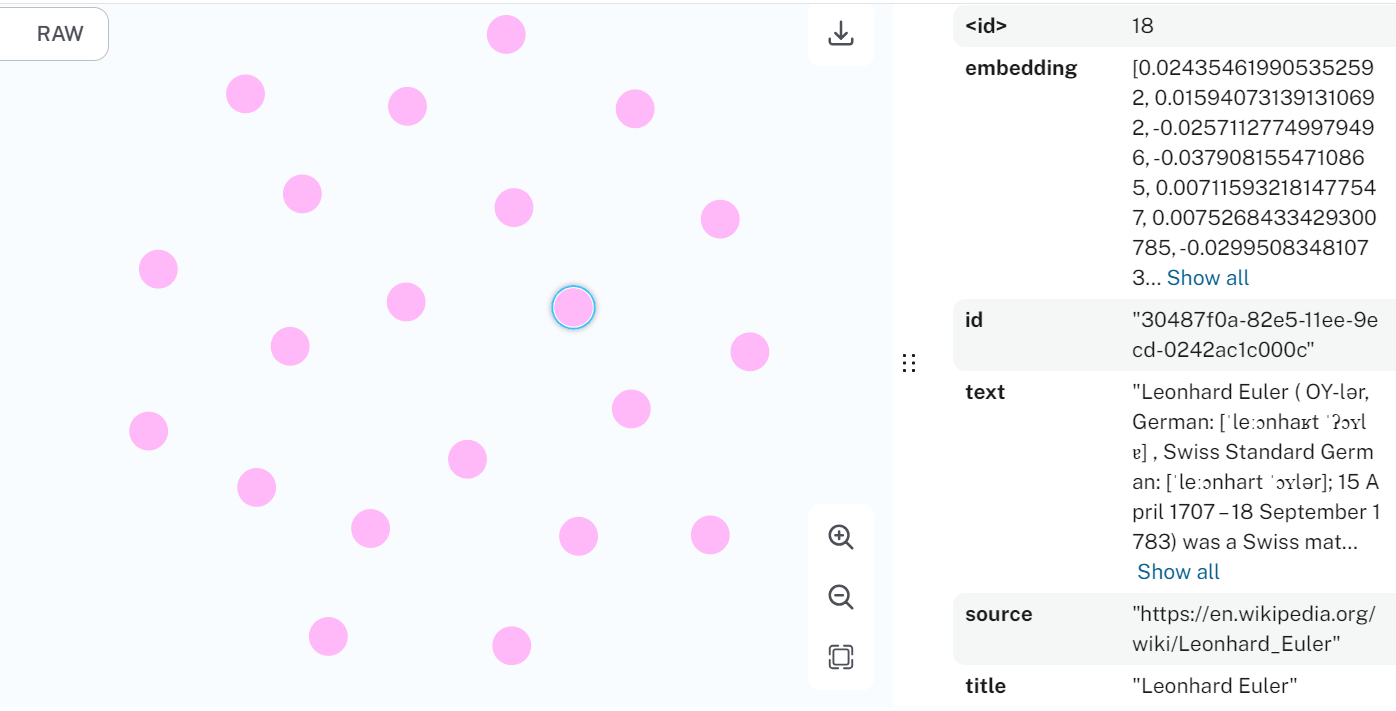

## Vector Similarity Search
using OpenAI (embedded function) to embed the question and find most similar documents

_The below code will return the most simlar indexed documents related to the question_


In [48]:
query = "Where did Euler grow up?"

results = neo4j_vector.similarity_search(query, k=1)
print(results[0].page_content)


== Early life ==
Leonhard Euler was born on 15 April 1707, in Basel to Paul III Euler, a pastor of the Reformed Church, and Marguerite (née Brucker), whose ancestors include a number of well-known scholars in the classics. He was the oldest of four children, having two younger sisters, An


## Question-Answer Workflow With LangChain

1.   List item
2.   List item


- LLM constructing accurate answers based on the documents
- Returns answer and the source

In [49]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain

chain = RetrievalQAWithSourcesChain.from_chain_type(
    ChatOpenAI(temperature=0),
    chain_type="stuff",
    retriever=neo4j_vector.as_retriever()
)


In [50]:
query = "What is Euler credited for popularizing?"

chain(
    {"question": query},
    return_only_outputs=True,
)


{'answer': "Euler is credited for popularizing modern notation and terminology in mathematics. He introduced the notation for functions, trigonometric functions, the base of the natural logarithm (Euler's number), the use of the Greek letter π to represent the ratio of a circle's circumference to its diameter, and the notation i to represent the imaginary unit. He also introduced the use of lowercase letters to represent the sides of a triangle and uppercase letters to represent the angles. Additionally, Euler made important contributions to complex analysis and",
 'sources': ''}

Adding the memory module to save chat history

In [51]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
qa = ConversationalRetrievalChain.from_llm(
    ChatOpenAI(temperature=0), neo4j_vector.as_retriever(), memory=memory)

print(qa({"question": "What is Euler credited for popularizing?"})["answer"])

# Follow up question
print(qa({"question": "Where did he grow up?"})["answer"])


Euler is credited for popularizing several mathematical concepts and notations. Some of the things he is credited for popularizing include:

1. The use of the Greek letter π (pi) to represent the ratio of a circle's circumference to its diameter.
2. The notation f(x) to represent a function.
3. The use of the letter i to represent the imaginary unit (√-1).
4. The modern notation for trigonometric functions.
5. The use of the letter e to represent the base of the natural logarithm (Euler's number).
6. The use of lowercase letters to represent the sides of a triangle and uppercase letters to represent the angles.
7. The use of the Greek letter Σ (sigma) to represent summations.
8. The use of the Greek letter Δ (delta) to represent finite differences.

These are just a few examples of the many mathematical concepts and notations that Euler is credited for popularizing.
Euler grew up in Basel, Switzerland.
